# Python Tutorial Seminar Series: Cartopy (4/28) #

This tutorial will cover the basics of Cartopy including: coordinate systems, map masking, map projection options, and Cartopy's many applications with geospatial data. We will also discuss best practices when it comes to choosing a colormap color scheme.

## 1. Import necessary packages and read in data ##
We will read in a couple different datasets here, but will use them in different examples throughout this tutorial. When a new dataset is being used, it will be marked clearly in the title and in the comments of the applicable code block.

You will noticed the "GeoCAT Specific Packages" below. These packages all us to have a who repository or datafiles without explicitly downloading them to your computer and offer some plotting/visualization convenience functions that are used later in this file. If you would like to learn more about the GeoCAT project, which includes a [Python plotting example library](https://geocat-examples.readthedocs.io/en/latest/), please visit the [GeoCAT project homepage](https://geocat.ucar.edu/pages/software.html).

In [3]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from wrf import (getvar, to_np, latlon_coords, get_cartopy)
from netCDF4 import Dataset

#GeoCAT Specific packages
from geocat.viz import util as gvutil
import geocat.datafiles as gdf

# Read in datasets using xarray and netCDF4
res = xr.open_dataset(gdf.get("netcdf_files/tpom000.partial.nc")) # Resolution example from coast_1
wrfin = Dataset(gdf.get("netcdf_files/wrfout_d03_2012-04-22_23_00_00_subset.nc")) # Zoom example from wrf_zoom
mask = xr.open_dataset(gdf.get("netcdf_files/atmos.nc"), decode_times=False) # Masking example from mask_5


## 2. Create a basic map projection using Cartopy ##
To start things off, we will create a very basic map projection that does not use any data. This is to serve as a warm up for the tutorial and help familiarize you with the Cartopy package. We will use the Cartopy feature interface (cfeature) to add geographic features like bodies of water, borders, and coastlines. When using cfeature, you are able to define different attributes 

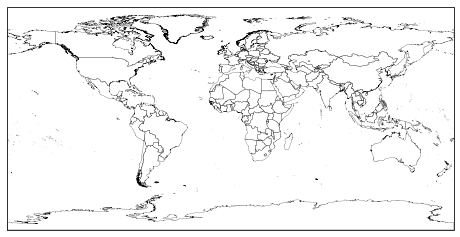

In [4]:
# Create and define the size of a figure object 
plt.figure(figsize=(8, 8))

# Create an axis with an basic PlateCarree projection style
ax = plt.axes(projection=ccrs.PlateCarree())

# Use different map projections 
# ax = plt.axes(


# Add natural features to map using cartopy.feature (cfeature)
#ax.add_feature(
#ax.add_feature(
#ax.add_feature(

# Add border lines over countries 
ax.add_feature(cfeature.NaturalEarthFeature(category='',
                                            name='',
                                            scale='10m',
                                            facecolor='none',
                                            edgecolor='black',
                                            linewidth=0.2))

# For a list of available features in NaturalEarthFeature visit: https://www.naturalearthdata.com/features/

## 3. Change resolution of projection features ##
Using dataset 'res', we will experiment with the different resolution options in Cartopy. We will also implement a color scheme that follows best practices for being more colorblind friendly. For more information on these practices, please refer to the GeoCAT-examples library 'colors' section found here: https://geocat-examples.readthedocs.io/en/latest/gallery/index.html#colors

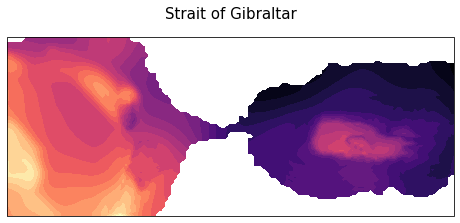

In [6]:
# Extract a specific time 'slice' of data
t = res.t

# Create a figure object
fig = plt.figure(figsize=(8, 6))

# Generate axes, using Cartopy, drawing coastlines, and adding features
projection = ccrs.PlateCarree()
ax1 = plt.axes(projection=projection)
#ax1.coastlines(
#ax1.add_feature(

# Contourf-plot data
temp = t.plot.contourf(ax=ax1,
                       transform=projection,
                       levels=25,
                       vmin=14.9,
                       vmax=17.3,
                       cmap='magma', # Using best practices when choosing a colormap color scheme
                       add_colorbar=False)

# Add a title to the map projection
plt.title('Strait of Gibraltar', x=.5, y=1.07, fontsize=15)
plt.show()

# Now try with the other two resolutions '50m' and '110m'

## 4. Zoom into a specific area on a map ##
For this example, we will 'zoom' into a specific location on the map. We will be using a WRF dataset for this example and will use a couple of wrf-python functions to help extract the data. To learn more about wrf-python software, please visit the wrf-python [readthedocs page](https://wrf-python.readthedocs.io/en/latest/).

By setting 'crs' and 'transform' to 'ccrs.PlateCarree()', the map projection will be able to add the Cartopy features like coastlines and bodies of water. This is due to the coordinate reference system (crs) of the data being PlateCarree and not LambertConformal (cart_proj).
More information is found on the [SciTools website](https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html#:~:text=The%20transform%20argument%20to%20plotting,your%20data%20are%20defined%20in.&text=This%20is%20because%20the%20default,been%20the%20case%20so%20far).

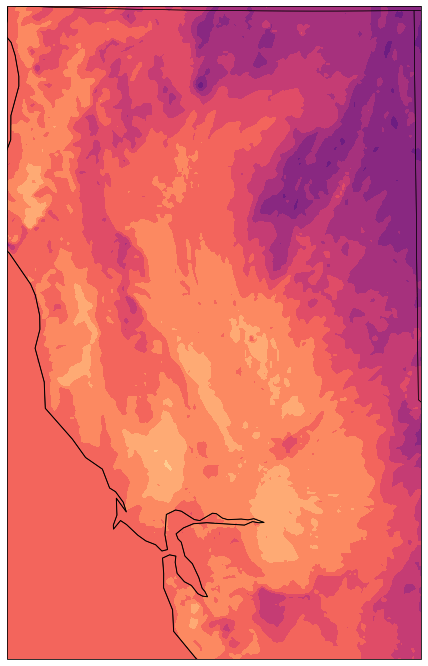

In [34]:
# Use WRF-python function to extract data variable for plotting
td2 = getvar(wrfin, "td2")

# The `get_cartopy` wrf function will automatically find and use the
# intended map projection for this dataset
cart_proj = get_cartopy(td2)

# Uncomment following line to view the exact map projection type
print(cart_proj)

# Create a figure object and generate axes
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=cart_proj)

# Add features to the projection
states = cfeature.NaturalEarthFeature(category="cultural",
                             scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

ax.add_feature(states, linewidth=0.5, edgecolor="black")
ax.coastlines('50m')

lons = td2['XLONG']
lats = td2['XLAT']

# Add filled dew point temperature contours
plt.contourf(to_np(lons),
             to_np(lats),
             to_np(td2),
             levels=13, cmap="magma",
             transform=ccrs.PlateCarree()) # Why do we switch the coordinate system here? (See below if viewing recording)

# Zoom into a specific area on the map 
ax.set_extent((-124, -120, 37, 42), crs=ccrs.PlateCarree())

# Add another NaturalEarthFeature 
#ax.add_feature(


### Why change the projection at the end? ###
In short, Cartopy needs latitude and longitude data to do transformed to PlateCarree. This allows Cartopy to transform the lat/lon coordinates into projected coordinates (in meters). If this change did not occur (if we had just used 'cart_proj' in each situation) we would not be able to see the added state border feature as it would be interpreting our spatial data as meters and not in degrees of lat/lon and thus incredibly small.

## 5. Mask a map projection ##
In this example, we will 'mask' a Cartopy map projection with data from our dataset. This allows us to, essentially, block out specific areas of data on the projection. 

Text(0.5, 1.0, 'No mask, data only')

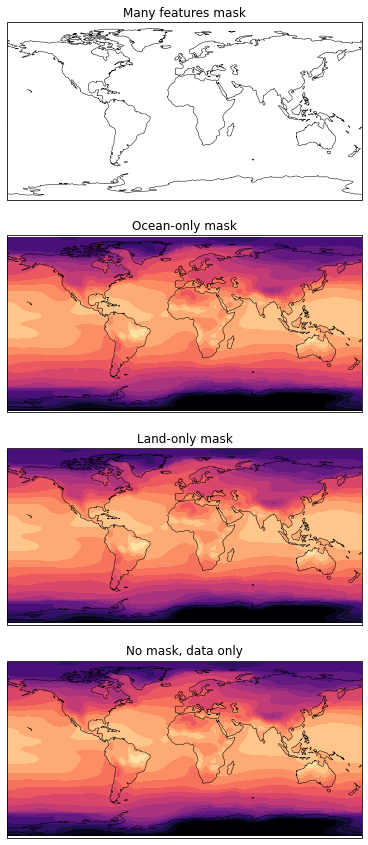

In [35]:
# Select a slice of the dataset
t = mask.TS.isel(time=0)

# Use a GeoCAT-viz function to fix the artifact of not-shown-data around 0 and 360-degree longitudes
t = gvutil.xr_add_cyclic_longitudes(t, "lon")

# Generate 
fig = plt.figure(figsize=(10, 15))

# Plot first plot
# Generate axes using Cartopy, draw coastlines, and add other map features
ax = plt.subplot(4, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines(linewidths=0.5)

# Lets mask out the LAND, LAKES, and OCEAN in this projection
#ax.add_feature(cfeature., color="")
#ax.add_feature(cfeature., color="")
#ax.add_feature(cfeature., color="")

plt.title("Many features mask")

# Plot second plot
ax1 = plt.subplot(4, 1, 2, projection=ccrs.PlateCarree())
ax1.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax1.coastlines(linewidths=0.5)

# Contourf-plot data
t.plot.contourf(ax=ax1,
                transform=ccrs.PlateCarree(),
                vmin=235,
                vmax=315,
                levels=18,
                cmap='magma',
                add_colorbar=False)


# Mask ocean data by changing adding ocean feature and changing its zorder
#ax1.add_feature(cfeature., zorder=1, color="", edgecolor="")

plt.title("Ocean-only mask")

# Plot third plot
ax2 = plt.subplot(4, 1, 3, projection=ccrs.PlateCarree())
ax2.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax2.coastlines(linewidths=0.5)

# Contourf-plot data
t.plot.contourf(ax=ax2,
                transform=ccrs.PlateCarree(),
                vmin=235,
                vmax=315,
                levels=18,
                cmap='magma',
                add_colorbar=False)


# Mask ocean data by changing adding ocean feature and changing its zorder
#ax2.add_feature(cfeature., zorder=1, color="", edgecolor="")

plt.title("Land-only mask")

# Plot fourth plot
ax3 = plt.subplot(4, 1, 4, projection=ccrs.PlateCarree())
ax3.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax3.coastlines(linewidths=0.5)

# Contourf-plot data
t.plot.contourf(ax=ax3,
                transform=ccrs.PlateCarree(),
                vmin=235,
                vmax=315,
                levels=18,
                cmap='magma',
                add_colorbar=False)


# Mask ocean data by changing adding ocean feature and changing its zorder
#ax3.add_feature(cfeature.LAND, zorder=10, color="green", edgecolor='k')

plt.title("No mask, data only")